In [199]:
import pandas as pd
import numpy as np
from langdetect import detect

import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import seaborn as sns
import re 
import math
from collections import defaultdict, Counter

import utils
# from graph import create_graph

In [2]:
# !pip install networkx 

In [233]:

# Open a file for reading
with open("../data/labels_per_category.json", "r") as f:
    # Write the dictionary to the file in JSON format
    ocms = json.load(f)

# Params

In [135]:
CHOSEN_CATEGORIES = True
LABELS_NEEDED_BEFORE = 626
ONLY_PARENT_CATEGORY = False
N_TO_SELECT = 10

# Split based on OCMs

In [5]:
df = pd.read_csv('../data/fpsc3.csv', encoding='utf-8')

In [89]:
pd.set_option('display.max_rows', 500)

In [ ]:
df.drop(['sectpar', 'sectgpar', 'hdoc', 'mainowc', '

In [90]:
df.head()

,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,byline,...,owcs,mainowc,samples,pub.lang,page,pageEid,prevPage,nextPage,textrecord,ocms
0,aa01-000-000178,aa01-000-000176,aa01-000-000164,NaN,Culture summary: Korea,aa01-000,Korea,NaN,no date,Choong Soon Kim and Ian Skoggard (file evaluat...,...,aa01,aa01,SCCSPS,English,5,aa01-000-000165,aa01-000-000129,aa01-000-000214,"Before the 1900s, Koreans lived as subsistence...",241 433
1,aa01-001-000341,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,aa01,aa01,SCCSPS,English,14-15,aa01-001-000331,aa01-001-000308,aa01-001-000347,{{245}} “Korea is richly endowed with fruits o...,245
2,aa01-001-000357,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,aa01,aa01,SCCSPS,English,15-16,aa01-001-000347,aa01-001-000331,aa01-001-000371,{{234}} {{243}} {{538}} {{824}} {{517}} “T...,234 243 517 538 824
3,aa01-001-000436,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,aa01,aa01,SCCSPS,English,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,{{243}} “Millet is the most ancient form of fo...,243
4,aa01-001-000442,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,aa01,aa01,SCCSPS,English,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,{{243}} {{252}} {{263}} “As rice is the nati...,243 252 263


# Visualization & Preprocessing

### Restructure columns

In [6]:
df['ocms'] = df['ocms'].apply(lambda x: x.replace('#', ''))

In [7]:
df.dropna(subset=['textrecord'], inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df[df['ocms'].apply(lambda x: min([int(l) for l in x.split()]) > LABELS_NEEDED_BEFORE)]

,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,byline,...,owcs,mainowc,samples,pub.lang,page,pageEid,prevPage,nextPage,textrecord,ocms


# Explore columns

In [ ]:
print(df.groupby('pub.lang')['textrecord'].count().sort_values(ascending=False).to_latex())

pub.lang
English                                                     176462
English and Assiniboine                                          1
English and Athabaskan                                          55
English and Cajun French                                         3
English and Delaware                                             3
English and French                                              32
English and Hawaiian                                           366
English and Hopi                                               291
English and Ifugao                                              60
English and Japanese                                            41
English and Klamath                                             63
English and Latin                                               12
English and Pageh                                               90
English and Russian                                             27
English and Spanish                                  

In [207]:
df[df['pub.lang'] == 'German, English, Indonesian']['textrecord']

149813    {{463 462 241 436 231 226 224}} Die Mentawaier...
149814    {{245}} Die Nahrungsgrundlage der Sakuddei ist...
149815    {{245 252}} Ein Baum braucht etwa zehn Jahre, ...
149816    [%  [caption:   {{252 142 412}} Abb. 35: Klopf...
149817    {{262}} Die so gewonnene Basisnahrung reicht f...
149818    [%  [caption:   {{142 302 291 252 415}} Abb. 3...
149819    [%  [caption:   {{142 302 291 417 245}} Abb. 3...
149820    {{262 824 285 342}} Sago gefüttert. Selbst der...
149821    {{245}} Zur Arbeit in den Sagosümpfen gehört d...
149822    {{245 433 311 583}} Die Sakuddei rechnen ihren...
149823    {{252 462 245}} Die Sagoverarbeitung ist Männe...
149824    {{252 462 245}} mit einem Grabstock neu bepfla...
149825    {{245 249 462}} Neben dem Taro pflanzen die Fr...
149826    Jede Frau unterhält ihre eigenen Taropflanzung...
149827    Viel ausgedehnter als die Tarofelder sind die ...
149828    {{241}} Gemeinschaftsarbeit von Mann und Frau ...
149829    Etwa eine Woche nach dem Fälle

In [208]:
df.iloc[149814].textrecord

'{{245}} Die Nahrungsgrundlage der Sakuddei ist der Sago ( ~~sagu~~ ). Die Sagopalmen wachsen wild in den sumpfigen Niederungen; weitere werden hinzugepflanzt. Dort werden die Bäume auch verarbeitet (vgl. Abb. 31 und 32). Anbau und Verarbeitung sind im Prinzip Aufgaben der Männer, obwohl gelegentlich auch die heranwachsenden Töchter mithelfen.'

**NOTE** since it is hard to check every row whether it's enlgish or not, I use a package that detects the language, and if it's not enlgish, the row will be removed.

In [210]:
# Define a function to detect the language of a text record
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

# Apply the detect_language function to the textrecord column
df["language"] = df["textrecord"].apply(detect_language)

# Filter out the records that are not in English
df = df[df["language"] == "en"]

In [209]:
detect(df.iloc[149814].textrecord)

'de'

In [211]:
df.groupby('pub.lang')['textrecord'].count()

pub.lang
English                                                     164853
English and Assiniboine                                          1
English and Athabaskan                                          50
English and Cajun French                                         3
English and Delaware                                             3
English and French                                              32
English and Hawaiian                                           339
English and Hopi                                               290
English and Ifugao                                              52
English and Japanese                                            41
English and Klamath                                             63
English and Latin                                               12
English and Pageh                                               90
English and Russian                                             27
English and Spanish                                  

In [212]:
df.to_csv('new_data.csv')

In [222]:
print(df.groupby('pub.lang')['textrecord'].count().sort_values(ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
 & textrecord \\
pub.lang &  \\
\midrule
English & 164853 \\
English translation from French & 7292 \\
English translation from German & 3857 \\
English translation from Spanish & 933 \\
English translation from Russian & 814 \\
English translation from Finnish & 743 \\
Latin and English & 659 \\
English translation from Portuguese & 602 \\
English with summary in French & 375 \\
English and Hawaiian & 339 \\
English and Hopi & 290 \\
English translation from Aztec & 238 \\
English translation from Italian & 184 \\
English translation from Serbian & 178 \\
English translation from Latin & 165 \\
English and Tongan & 162 \\
English translation from Netherlandish & 159 \\
English translation from the German & 98 \\
English translation from Chinese & 96 \\
English and dialects of Malekula & 95 \\
English and Pageh & 90 \\
English translation from Italian(?) & 90 \\
English with some Spanish and Cuna & 89 \\
English translation from the French & 84 \\
English t

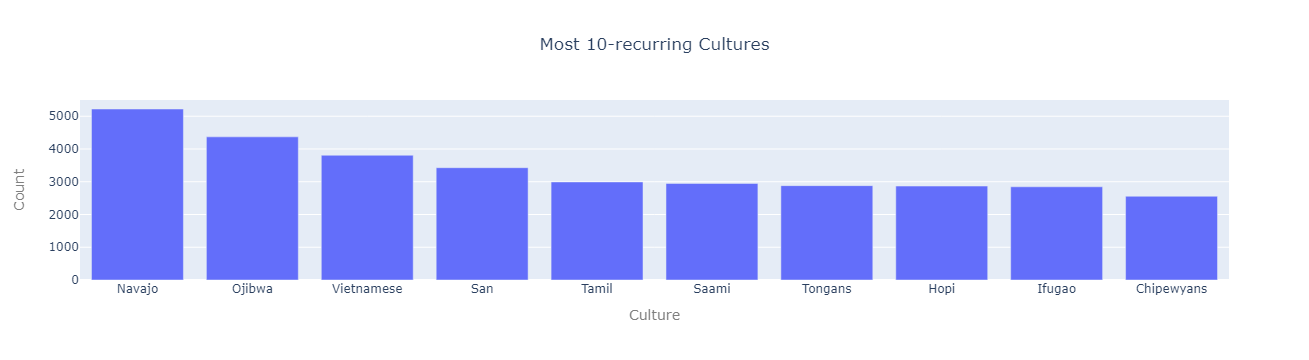

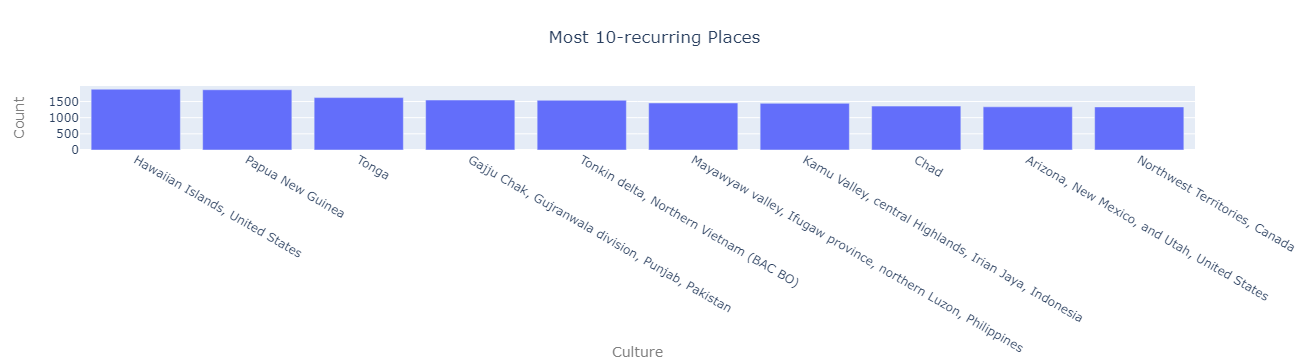

In [224]:

layout = go.Layout(
    yaxis=dict(title = go.layout.yaxis.Title(text='Count', font=dict(size=14, color='#7f7f7f'))),
    xaxis=dict(title = go.layout.xaxis.Title(text='Culture', font=dict(size=14, color='#7f7f7f')))
)

fig = go.Figure(
    data=[go.Bar(x=[l for l, _ in sorted_culture_counts[:N_TO_SELECT]], 
                 y=[count for _, count in sorted_culture_counts[:N_TO_SELECT]])],
    layout=layout,
    layout_title=f'Most {N_TO_SELECT}-recurring Cultures',
    layout_title_x=0.5,
)


fig1 = go.Figure(
    data=[go.Bar(x=[l for l, _ in sorted_place_counts[:N_TO_SELECT]], 
                 y=[count for _, count in sorted_place_counts[:N_TO_SELECT]])],
    layout=layout,
    layout_title=f"Most {N_TO_SELECT}-recurring Places",
    layout_title_x=0.5,
)

fig.write_image(f'{ONLY_PARENT_CATEGORY}_culture_counts.png')
fig.show()
fig1.write_image(f'{ONLY_PARENT_CATEGORY}_place_counts.png')
fig1.show()

In [227]:
df.groupby('samples')['textrecord']

In [77]:
sorted_culture_counts = sorted(list(df.groupby('culture')['ocms'].count().items()), reverse=True,
       key=lambda x: x[1])

sorted_place_counts = sorted(list(df.groupby('place')['ocms'].count().items()), reverse=True,
       key=lambda x: x[1])

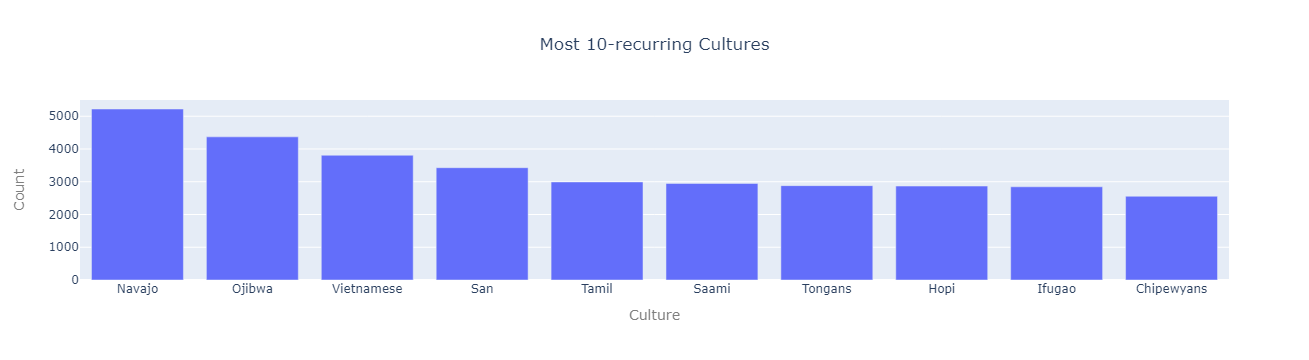

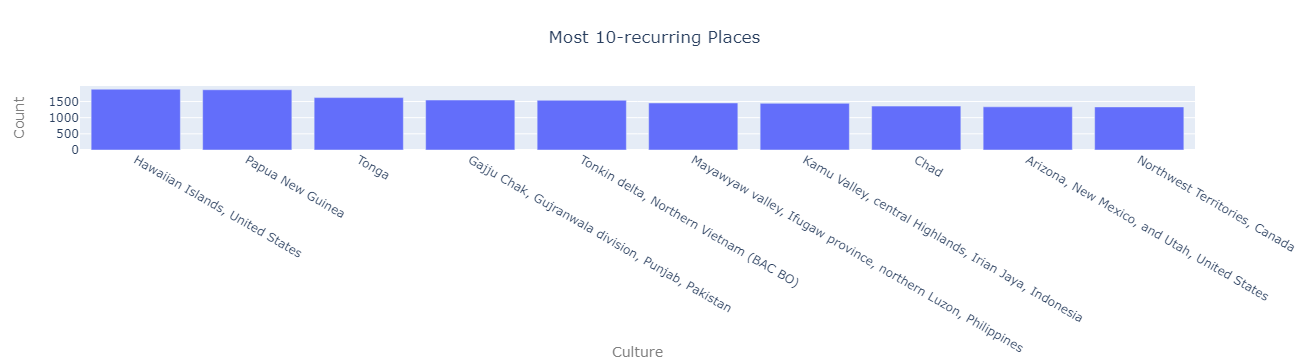

In [96]:

layout = go.Layout(
    yaxis=dict(title = go.layout.yaxis.Title(text='Count', font=dict(size=14, color='#7f7f7f'))),
    xaxis=dict(title = go.layout.xaxis.Title(text='Culture', font=dict(size=14, color='#7f7f7f')))
)

fig = go.Figure(
    data=[go.Bar(x=[l for l, _ in sorted_culture_counts[:N_TO_SELECT]], 
                 y=[count for _, count in sorted_culture_counts[:N_TO_SELECT]])],
    layout=layout,
    layout_title=f'Most {N_TO_SELECT}-recurring Cultures',
    layout_title_x=0.5,
)


fig1 = go.Figure(
    data=[go.Bar(x=[l for l, _ in sorted_place_counts[:N_TO_SELECT]], 
                 y=[count for _, count in sorted_place_counts[:N_TO_SELECT]])],
    layout=layout,
    layout_title=f"Most {N_TO_SELECT}-recurring Places",
    layout_title_x=0.5,
)

fig.write_image(f'{ONLY_PARENT_CATEGORY}_culture_counts.png')
fig.show()
fig1.write_image(f'{ONLY_PARENT_CATEGORY}_place_counts.png')
fig1.show()

In [230]:
with open("../data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

id_to_label = {int(i): l for i, l in id_to_label.items()}
label_to_id = {v: k for k, v in id_to_label.items()}

In [234]:
id_to_category = {000: 000}
for item in ocms:
    category, values = list(item.items())[0]
    cat_id = label_to_id[category]
    
    id_to_category[cat_id] = cat_id
    for x in values:
        id_to_category[int(x[0])] = cat_id
    

In [235]:
id_to_label[222], id_to_category[221]

('collecting', 220)

In [236]:
ocms_counts = utils.get_ocm_counts(df, id_to_category if ONLY_PARENT_CATEGORY else None, 
                                   limit=LABELS_NEEDED_BEFORE)


In [237]:
for ocm in ocms_counts.most_common(N_TO_SELECT):
    print(id_to_label[ocm[0]], ocm)

tillage (241, 46381)
hunting and trapping (224, 30864)
cereal agriculture (243, 22816)
fishing (226, 21697)
annual cycle (221, 18274)
diet (262, 13668)
social control (626, 12744)
vegetable production (244, 11822)
production and supply (433, 11366)
real property (423, 10975)


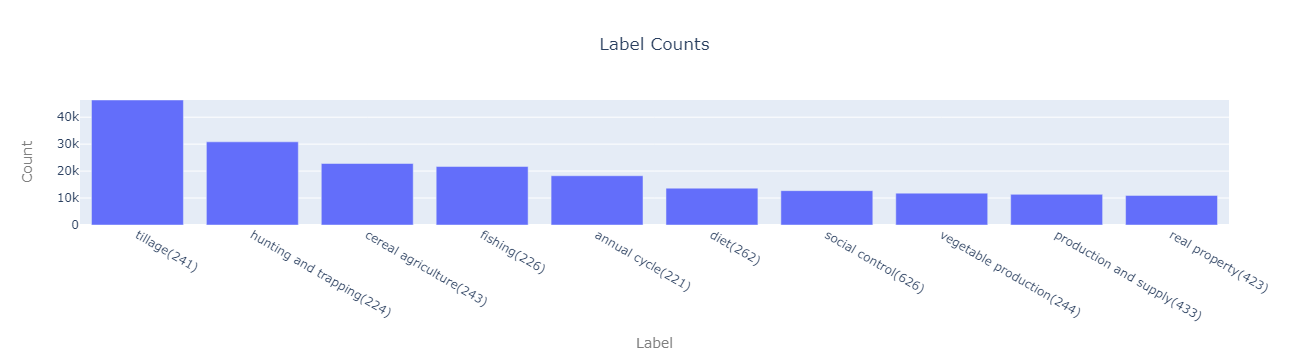

In [238]:
layout = go.Layout(
    title='Label Counts',
    title_x=0.5,
    yaxis=dict(range=[-4, ocms_counts.most_common(1)[0][1]],
    title = go.layout.yaxis.Title(text='Count', font=dict(size=14, color='#7f7f7f'))),
    xaxis=dict(title = go.layout.xaxis.Title(text='Label', font=dict(size=14, color='#7f7f7f')))
)

fig = go.Figure(
    data=[go.Bar(x=[f'{id_to_label[ocm[0]]}({ocm[0]})' for ocm in ocms_counts.most_common(N_TO_SELECT)], 
                 y=[ocm[1] for ocm in ocms_counts.most_common(N_TO_SELECT)])],
    layout=layout,
)
fig.write_image(f'{"Parent " if ONLY_PARENT_CATEGORY else ""}Categories.png')
fig.show()

In [239]:
# ocms_counts.pop(0)

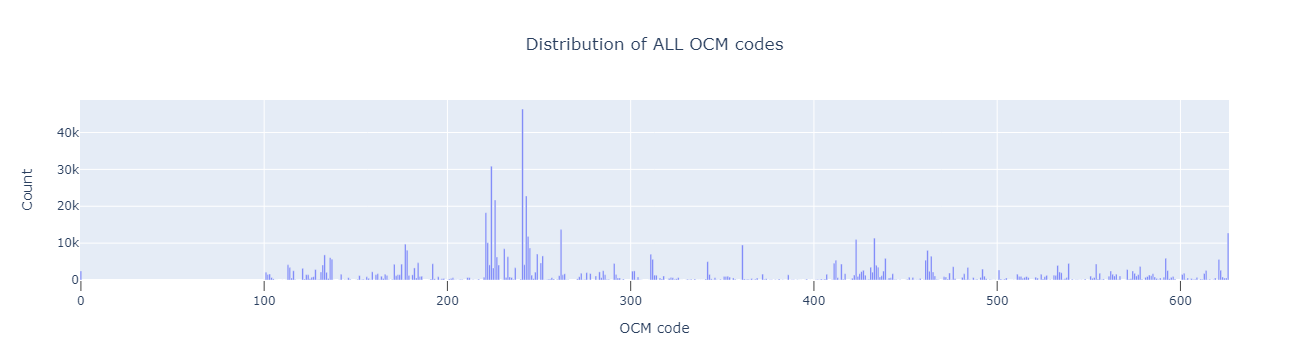

In [240]:
# create a list of OCM codes and their corresponding counts
ocms = list(ocms_counts.keys())
counts = list(ocms_counts.values())

fig = go.Figure(
    # data=[go.Bar(x=ocms, y=counts)],
    data=[go.Bar(x=ocms, y=counts)],
    layout_title_text=f"Distribution of {'' if ONLY_PARENT_CATEGORY else 'ALL '}OCM codes",
    layout_title_x=0.5
)
fig.update_xaxes(title='OCM code', ticks="outside", showgrid=True, ticklen=10)
fig.update_yaxes(title="Count")
fig.write_json('test.json')
fig.write_image(f'OCM_dist{"" if ONLY_PARENT_CATEGORY else "_all"}.png')
fig.show()


**NOTE** after observing that categories between the first and fifth after the tenth, i decided to group by parent categories. For instnace, 241, 245 or 249 would link to 240 and so on.

# Visualization 2

In [241]:
ONLY_PARENT_CATEGORY = True

In [242]:
ocms_counts = utils.get_ocm_counts(df, id_to_category if ONLY_PARENT_CATEGORY else None, 
                                   limit=LABELS_NEEDED_BEFORE)

In [111]:
ocms_counts.pop(0)

2847

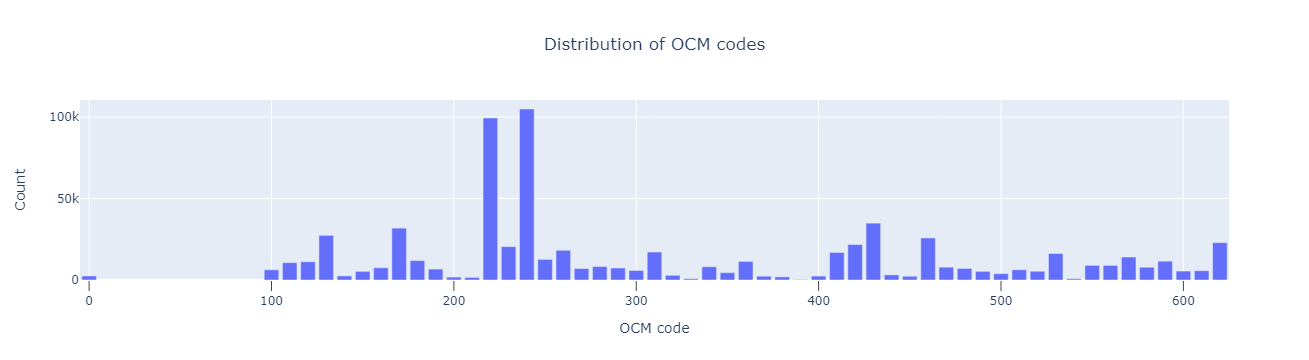

In [243]:
# create a list of OCM codes and their corresponding counts
ocms = list(ocms_counts.keys())
counts = list(ocms_counts.values())

fig = go.Figure(
    # data=[go.Bar(x=ocms, y=counts)],
    data=[go.Bar(x=ocms, y=counts)],
    layout_title_text=f"Distribution of {'' if ONLY_PARENT_CATEGORY else 'ALL '}OCM codes",
    layout_title_x=0.5
)
fig.update_xaxes(title='OCM code', ticks="outside", showgrid=True, ticklen=10)
fig.update_yaxes(title="Count")
fig.write_json('test.json')
fig.write_image(f'OCM_dist{"" if ONLY_PARENT_CATEGORY else "_all"}.png')
fig.show()


In [244]:
# CHECK OUT: 310, 340, 400, 520, 570, 580, 870] activities, building structures, machines, recreation, interpersonal relations, marriage, education.
chosen_categories = [140, 150, 160, 170, 180, 190, 200, 220, 240, 260, 360, 420, 430, 590, 620]#, 780, 820]

In [245]:
def top_n_count(ocm_id, n=400):
    top_400 = any([ocm_id == y[0] for y in ocms_counts.most_common(n)])
    x_i = list(map(lambda x:x[0], ocms_counts.most_common(n))).index(ocm_id)

    return top_400, x_i , ocms_counts[ocm_id]

In [246]:
for ocm_id in chosen_categories:
    print(f'"{id_to_label[ocm_id].capitalize()}" id({ocm_id}) count{top_n_count(ocm_id)}\n')

"Human biology" id(140) count(True, 43, 2496)

"Behavior processes and personality" id(150) count(True, 37, 5317)

"Demography" id(160) count(True, 26, 7493)

"History and culture change" id(170) count(True, 3, 31813)

"Total culture" id(180) count(True, 15, 11900)

"Language" id(190) count(True, 30, 6697)

"Communication" id(200) count(True, 49, 1784)

"Food quest" id(220) count(True, 1, 99312)

"Agriculture" id(240) count(True, 0, 104869)

"Food consumption" id(260) count(True, 9, 18225)

"Settlements" id(360) count(True, 17, 11421)

"Property" id(420) count(True, 7, 21737)

"Exchange and transfers" id(430) count(True, 2, 34869)

"Family" id(590) count(True, 16, 11535)

"Community" id(620) count(True, 6, 22891)



# Preprocessing

- placeholders within {{}}.
- multiple may occur within the pattern.
- anything within [ ] should be excluded, since these are pictures or links.
- 

In [129]:
# df.iloc[212] # VERY WEIRD!!

In [147]:
df.iloc[31144]

sreid                                           aw42-001-001104
section                                         aw42-001-000481
sectpar                                         aw42-001-000458
sectgpar                                                    NaN
title         The Santal: a tribe in search of a great tradi...
hdoc                                                   aw42-001
culture                                                  Santal
pub.date                                                   1965
field.date                                            1957-1958
byline                                          by Martin Orans
sreprev                                         aw42-001-001098
srenext                                       aw42-001-001104-0
parent                                          aw42-001-000481
division                                        aw42-001-000447
coverage                                          not specified
place                                   

In [153]:
df.iloc[31145]

sreid                                         aw42-001-001104-0
section                                         aw42-001-000481
sectpar                                         aw42-001-000458
sectgpar                                                    NaN
title         The Santal: a tribe in search of a great tradi...
hdoc                                                   aw42-001
culture                                                  Santal
pub.date                                                   1965
field.date                                            1957-1958
byline                                          by Martin Orans
sreprev                                         aw42-001-001104
srenext                                         aw42-001-001120
parent                                          aw42-001-001104
division                                        aw42-001-000447
coverage                                          not specified
place                                   

In [19]:
df[df['sreid'] == 'aa01-007-002174'].textrecord

378    {{249}} For the seasoning of foods and for the...
Name: textrecord, dtype: object

In [21]:
df[df['sreid'] == 'aa01-007-002174-0'].textrecord

379    [%  [caption:  TABLE 29. AVERAGE ACREAGE, PROD...
Name: textrecord, dtype: object

In [154]:
df.iloc[31146]

sreid                                           aw42-001-001211
section                                         aw42-001-000481
sectpar                                         aw42-001-000458
sectgpar                                                    NaN
title         The Santal: a tribe in search of a great tradi...
hdoc                                                   aw42-001
culture                                                  Santal
pub.date                                                   1965
field.date                                            1957-1958
byline                                          by Martin Orans
sreprev                                         aw42-001-001203
srenext                                       aw42-001-001211-0
parent                                          aw42-001-000481
division                                        aw42-001-000447
coverage                                          not specified
place                                   

In [20]:
id_to_label[626]

'social control'

In [255]:
test = df.iloc[89687].textrecord  
test[:4327]

"Lewis and Clark, whose visit was brief, list but three bands: Canoe (700 individuals), Girl's (850), and Big Devil (1600) or the later Mountain Village bands. Under __Remarks,__ they wrote: “These bands act entirely independent of each other, although they claim a natural affinity and never make war on each other (49).”"

In [247]:
def get_parent_category_i(cat):
    return math.floor(int(cat) / 10) * 10

#TODO
- if no OCMs in text, take the ones in the columns with the whole text instead.
- detect EN only one time (use the saved one for now)
- plot other interesting columns. If none, remove the rest.

In [267]:
def split_data(row):
    text = row['textrecord']
    print(text)
    text = re.sub(r"\[%.*?%\]", "", text) # exclude text within [%  %]

    sentences = re.split(r'\{\{(\d+(\s+\d+)*)\}\}', text.strip())

    filtered_ocms = []
    filtered_sentences = []
    used_per_sentence = defaultdict(list)
    current_labels = []
    for i, s in enumerate(sentences):
        if s and s.strip() != '':
            s = s.strip()
            if re.match(r"\d+", s):
                for cat in s.split():
                    # print(used_per_sentence.get(len(filtered_sentences)))
                    already_used = used_per_sentence.get(len(filtered_sentences))
                    if not already_used or (cat not in already_used):
                        # print(s)
                        current_labels.append(get_parent_category_i(cat) if ONLY_PARENT_CATEGORY else int(cat))
                        # filtered_ocms.append((len(filtered_sentences), get_parent_category_i(cat) if ONLY_PARENT_CATEGORY else cat))
                        used_per_sentence[len(filtered_sentences)] = cat
            else:
                # group 
                filtered_sentences.append(s)
                filtered_ocms.append(current_labels)
                current_labels = []
    return [{**row, 
             'textrecord': t, 
             'ocms': ocm, 'count': ocms_counts[ocm], 'label_name': id_to_label[ocm],
             'parent_ocms': get_parent_category_i(ocm), 'parent_label_name': id_to_label[get_parent_category_i(ocm)]} 
            for i, t in enumerate(filtered_sentences)
            for ocm in filtered_ocms[i] 
            if ocm <= LABELS_NEEDED_BEFORE
           ]#if CHOSEN_CATEGORIES and ocm in chosen_categories]
    return filtered_sentences, filtered_ocms

In [263]:
test

"Lewis and Clark, whose visit was brief, list but three bands: Canoe (700 individuals), Girl's (850), and Big Devil (1600) or the later Mountain Village bands. Under __Remarks,__ they wrote: “These bands act entirely independent of each other, although they claim a natural affinity and never make war on each other (49).”"

In [269]:
df.iloc[89687]

sreid                                           nf04-025-002648
section                                         nf04-025-002551
sectpar                                         nf04-025-001810
sectgpar                                                    NaN
title                   The Fort Belknap Assiniboine of Montana
hdoc                                                   nf04-025
culture                                             Assiniboine
pub.date                                                   1938
field.date                                                 1935
byline                                       [by] David Rodnick
sreprev                                         nf04-025-002642
srenext                                         nf04-025-002655
parent                                          nf04-025-002551
division                                        nf04-025-000155
coverage                                              1640-1935
place                                   

In [268]:
pd.DataFrame(df.iloc[89687]).apply(split_data, axis=0)
# [{'text': t, 'ocm': ocm} for i, t in enumerate(filtered_sentences) for ocm in filtered_ocms[i]]

Lewis and Clark, whose visit was brief, list but three bands: Canoe (700 individuals), Girl's (850), and Big Devil (1600) or the later Mountain Village bands. Under __Remarks,__ they wrote: “These bands act entirely independent of each other, although they claim a natural affinity and never make war on each other (49).”


,99459


In [123]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [139]:
all_data = []
for item in df.apply(split_data, axis=1):
    if item:
        [all_data.append(i) for i in item]

In [141]:
pd.DataFrame(all_data)

,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,byline,...,page,pageEid,prevPage,nextPage,textrecord,ocms,count,label_name,parent_ocms,parent_label_name
0,aa01-001-000341,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,14-15,aa01-001-000331,aa01-001-000308,aa01-001-000347,“Korea is richly endowed with fruits of almost...,245,9633,arboriculture,240,agriculture
1,aa01-001-000357,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,15-16,aa01-001-000347,aa01-001-000331,aa01-001-000371,"“The question of cereals is, of course, of pri...",234,1078,dairying,230,animal husbandry
2,aa01-001-000357,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,15-16,aa01-001-000347,aa01-001-000331,aa01-001-000371,"“The question of cereals is, of course, of pri...",243,25723,cereal agriculture,240,agriculture
3,aa01-001-000357,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,15-16,aa01-001-000347,aa01-001-000331,aa01-001-000371,"“The question of cereals is, of course, of pri...",538,822,literature,530,art
4,aa01-001-000357,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,15-16,aa01-001-000347,aa01-001-000331,aa01-001-000371,"“The question of cereals is, of course, of pri...",517,717,leisure time activities,510,living standards and routines
5,aa01-001-000436,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,“Millet is the most ancient form of food known...,243,25723,cereal agriculture,240,agriculture
6,aa01-001-000442,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,"“As rice is the national dish, we naturally ex...",243,25723,cereal agriculture,240,agriculture
7,aa01-001-000442,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,"“As rice is the national dish, we naturally ex...",252,7645,food preparation,250,food processing
8,aa01-001-000442,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,17,aa01-001-000426,aa01-001-000371,aa01-001-000454,"“As rice is the national dish, we naturally ex...",263,1811,condiments,260,food consumption
9,aa01-001-000480,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,...,18-19,aa01-001-000470,aa01-001-000454,aa01-001-000488,"“The Koreans are great lovers of flowers, thou...",247,370,floriculture,240,agriculture


In [143]:
df[df['sreid'] == 'aa01-001-000799']

,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,byline,sreprev,srenext,parent,division,coverage,place,roll,pub.type,owcs,mainowc,samples,pub.lang,page,pageEid,prevPage,nextPage,textrecord,ocms
9,aa01-001-000799,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,aa01-001-000779,aa01-001-000819,aa01-001-000028,aa01-001-000027,Early 1900's,Korea,NaN,"Component part(s), monograph",aa01,aa01,SCCSPS,English,25-26,aa01-001-000789,aa01-001-000757,aa01-001-000809,{{136}} {{226}} {{228}} “More important than...,#136 #226 #228


In [144]:
df[df['sreid'] == 'aa01-001-000819']

,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,byline,sreprev,srenext,parent,division,coverage,place,roll,pub.type,owcs,mainowc,samples,pub.lang,page,pageEid,prevPage,nextPage,textrecord,ocms
10,aa01-001-000819,aa01-001-000028,NaN,NaN,The passing of Korea,aa01-001,Korea,NaN,1890-1905,[by] Homer B. Hulbert,aa01-001-000799,aa01-001-000839,aa01-001-000028,aa01-001-000027,Early 1900's,Korea,NaN,"Component part(s), monograph",aa01,aa01,SCCSPS,English,26,aa01-001-000809,aa01-001-000789,aa01-001-000829,{{222}} {{225}} {{262}} “But fish and pearls...,#222 #225 #262


In [ ]:
fil

In [158]:
matches[0]

'{{444}}'

In [170]:
import re

test = "[%  [caption:   {{221 241 821 796}}  Chart 2 The Annual Economic Cycle in Matsunagl [/caption]  [graphic: ab43007020]  [/graphic] %] [%  [caption:   {{221 241 821 796}}  Chart 2 The Annual Economic Cycle in Matsunagl [/caption]  [graphic: ab43007020]  [/graphic] %] {{243}}  {{412}} Even today some of the old methods of threshing persist."

pattern = r'\{\{(\d+(\s+\d+)*)\}\}'

# exclude text within [%  %]
test = re.sub(r"\[.*\]", "", test)
print(test)

sentences = re.split(pattern, test)

print(sentences)

 {{243}}  {{412}} Even today some of the old methods of threshing persist.
[' ', '243', None, '  ', '412', None, ' Even today some of the old methods of threshing persist.']


In [14]:
# Basic statistics of the numerical columns
print(df.describe())

# Basic statistics of the non-numerical columns
print('\nnon-numerical columns: \n', df.describe(include=['O']))

# Count of unique values in the non-numerical columns
print(df.nunique())

                section                                              title  \
count              5218                                               5218   
unique             5218                                               1679   
top     aa01-008-000031  Herds of the tundra: a portrait of Saami reind...   
freq                  1                                                 63   

        culture pub.date field.date            byline  \
count      5218     5044       5218              5217   
unique      308      267        845              1482   
top     Turkana     1994    no date  Cornelius Osgood   
freq        178      142        589                87   

                                               textrecord  ocms  
count                                                5218  5218  
unique                                               5218  4878  
top     {{241}}  {{311}} As a result of the porous qua...   221  
freq                                                    1  

In [25]:

# Convert the pub.date column to numeric
df['pub.date'] = pd.to_numeric(df['pub.date'], errors='coerce')

# Convert the field.date column to numeric
df['field.date'] = pd.to_numeric(df['field.date'], errors='coerce')


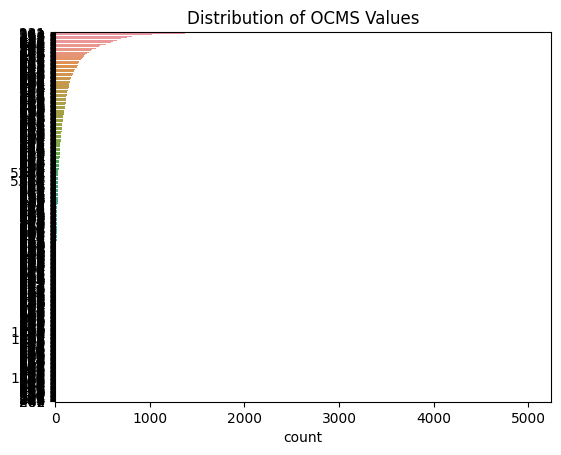

In [31]:

# Count the occurrences of values in each row for the ocms column
ocms_counts = df['ocms'].str.split(expand=True).stack().value_counts()

# Plot the distribution of ocms values
sns.countplot(y=df['ocms'].str.split(expand=True).stack(), order=ocms_counts.index)
plt.title("Distribution of OCMS Values")
plt.show()

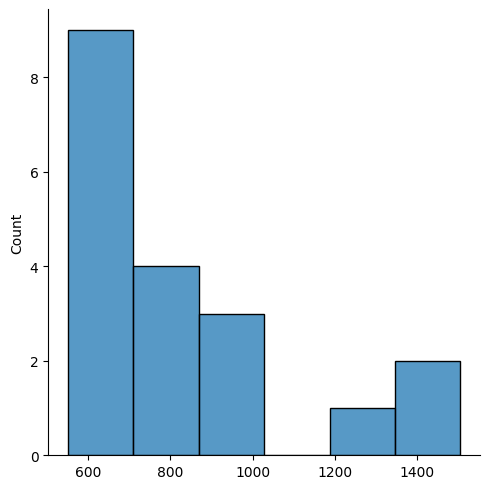

In [40]:
sns.displot(ocms_counts[1:20], )

In [16]:

# Plot the distribution of the culture target variable
sns.barplot(x="culture", data=df)
plt.title("Distribution of Culture")
plt.show()

# Plot the correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Plot a histogram of the publication dates
sns.histplot(x="pub.date", data=df)
plt.title("Distribution of Publication Dates")
plt.show()

# Plot a scatter plot of field date versus publication date
sns.scatterplot(x="field.date", y="pub.date", data=df)
plt.title("Field Date vs. Publication Date")
plt.show()

# Create a box plot of text record length by culture
sns.boxplot(x="culture", y="textrecord", data=df)
plt.title("Text Record Length by Culture")
plt.show()

TypeError: Horizontal orientation requires numeric `x` variable.